In [1]:
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import time
%matplotlib inline

In [2]:
def random_exp_time(n, rate=1):
    """
    Return a random vector with n entries, 
    each beingn a waiting time which is exponentially
    distributed.
    """
    if rate <= 0:
        return np.array([np.inf])
    return -1.0/rate * np.log(np.random.rand(n))

def nearest_neighbor_walk(n, p, h):
    """
    Return a n-array of {0, -1, 1} with probability p being not 0, 
    and a bias of h (h=1 has no bias while h=0 means always -1).
    """
    rand_vec = np.random.rand(n)
    p_left = p / (1.0 + h)
    p_right = p * h / (1.0 + h)
    move_prob = np.greater(p_left + p_right, rand_vec)
    move_left_prob = np.greater(p_left, rand_vec)
    return move_prob - 2 * move_prob * move_left_prob

def compute_bins(series):
    """
    Friedman-Diaconis rule of thumb for histogram bin number
    """
    iqr = stats.iqr(series)
    n = series.size
    bins = (series.max() - series.min()) / (2 * iqr * n ** (-1/3.0))
    #print "iqr, n, bins, max, min"
    #print iqr, n, bins, series.max(), series.min(), (np.isnan(bins) or np.isinf(bins))
    if np.isnan(bins) or np.isinf(bins):
        return 10 # return default
    return int(bins)

def get_equilibrium_time(series, min_points = 50):
    """
    Return the index at which equilibrium occur. 
    Equilibrium condition being that the moving window mean 
    is within half the standard deviation of the series mean.
    """
    series = np.array(series)
    mean = np.mean(series)
    std = np.std(series)
    for i in range(len(series)):
        window_mean = np.mean(series[:i])
        if abs(window_mean - mean) < 0.5 * std:
            return max(i, min_points)
    return min_points

def plot_series(series, x=None, ax=None, alpha=1, title='', color=None):
    if type(x) in [list, np.ndarray]:
        ax.plot(x, series, alpha=alpha, color=color)
    else:
        ax.plot(series, alpha=alpha, color=color)
    if title:
        ax.set_title("%s \nMean: %.2f Median: %.2f Std: %.2f" 
                     % (title, np.mean(series), np.median(series), np.std(series)))
    return ax


## Generalise 
---
Generalise the above simulation to take in any parameters

In [11]:
class Simulate_Continuous(object):
    def __init__(self, num_init=500, init_dist=None,
                 gamma=None, kappa=None, epsilon=None, mutation_rate=None,
                 tau=0.001, delta=0.01, num_generation=100,
                 walk_generator=None):
        self.gamma = gamma
        self.kappa = kappa
        self.epsilon = epsilon
        self.mutation_rate = mutation_rate / tau
        self.tau = tau
        self.delta = delta
        self.num_generation = num_generation
        self.walk_generator = walk_generator
        
        self.num_init = num_init
        if type(init_dist) != np.ndarray:
            self.init_dist = np.zeros(self.num_init)
        elif init_dist.size == num_init:
            self.init_dist = init_dist
        else:
            print "Initial distribution has size != num_init"
        
        self.realisations = []
    
    def realise(self, verbose=False):
        agents = self.init_dist
        population_n = [agents.size]
        pheno_mean = [agents.mean()]
        pheno_median = [np.median(agents)]
        t_n = [0]
        for n in range(self.num_generation):
            current_population = agents.size
            if current_population == 0:
                population_n.append(current_population)
                pheno_mean.append(0)
                pheno_median.append(0)
                t_n.append(t_n[-1] + self.tau)
                print "Extinction at generation: %i" % n
                break
            # obtain all the clocks = a 3 x current_population matrix
            bn = self.gamma # self.kappa * current_population
            walk_clocks = random_exp_time(current_population, self.mutation_rate)
            birth_clocks = random_exp_time(current_population, bn)
            death_clocks = [random_exp_time(1, 
                            self.kappa * current_population 
                                            + self.epsilon * (self.delta * agents[i])**2)[0]
                            for i in range(current_population)]
            clocks = np.concatenate([birth_clocks, death_clocks, walk_clocks])
            sorted_index = clocks.argsort()
            
            new_agents = []
            remove_index = []
            event_tally = [0, 0, 0]
            time_elapsed = 0
            num_updates = 0
            max_num_updates = sorted_index.size
            while time_elapsed < self.tau and num_updates < max_num_updates:
                index = sorted_index[num_updates]
                event = index // current_population
                event_tally[event] += 1
                agent_index = index % current_population
                if event == 0: # birth clock rang
                    new_agents.append(agents[agent_index])
                elif event == 1: # death knocks
                    remove_index.append(agent_index)
                elif event == 2: # mutation
                    agents[agent_index] += self.walk_generator()
                else: # something else going on, error
                    raise RuntimeError
                num_updates += 1
                time_elapsed = clocks[index]
            # update the agents
            agents = np.delete(agents, remove_index)
            agents = np.append(agents, new_agents)
            population_n.append(agents.size)
            t_n.append(t_n[-1] + time_elapsed)
            pheno_mean.append(agents.mean())
            pheno_median.append(np.median(agents))
            if n % 10 == 0 and verbose:
                print ("gen: %i, t: %.4f n_updates: %i prev_size: %i size: %i \n"
                       "events: %s b: %f d: %f\n" 
                       % (n, time_elapsed, num_updates, 
                          current_population, agents.size, str(event_tally), 
                          np.mean(birth_clocks), np.mean(death_clocks)))
        self.realisations.append({"agents":agents, "time":t_n, "population_n":population_n,
                                 "pheno_mean":pheno_mean, "pheno_median":pheno_median})
        return 
    
    def add_realisation(self, n, verbose=False):
        for i in range(n):
            np.random.seed(int(time.time()))
            self.realise(verbose=verbose)
        return 
    
    def report_avg_realisation(self, xlim=None):
        num_realisation = len(self.realisations)
        print "Number of realisations: %i" % num_realisation
        if num_realisation == 0:
            print "No realisation"
            return 
        agents_n = []
        extinction_time = []
        for item in self.realisations:
            if 0 in item['population_n']:
                extinction_time.append(item['population_n'].index(0))
            else:
                agents_n.append(item["agents"])
        
        num_extinction = len(extinction_time)
        if num_extinction > 0:
            p_extinct = float(num_extinction) / num_realisation
            avg_ext_time = np.mean(extinction_time)
            print ("%i extinction event out of %i realisation\np_extinct ~ %.2f\navg_ext_time: %.2f" 
                   % (num_extinction, num_realisation,p_extinct, avg_ext_time))
        fig, axes = plt.subplots(5, 2, figsize = (7 * 2, 4 * 7))
        if agents_n:
            agents_n = np.concatenate(agents_n)
            equi_mean = agents_n.mean()
            equi_num_agents = agents_n.size
            equi_median = np.median(agents_n)
            equi_std = np.std(agents_n)
            equi_iqr = stats.iqr(agents_n)
            
            axes[0][0].hist(agents_n, bins=compute_bins(agents_n))
            axes[0][0].set_title("Equilibrium Phenotype distribution\nMean: %.2f Median: %.2f Std: %.2f Total: %s"
                              % (equi_mean, equi_median, equi_std, equi_num_agents))
            if xlim:
                axes[0][1].set_xlim(xlim)
            sns.distplot(agents_n, ax=axes[0][1])
            xmin, xmax = axes[0][0].get_xlim()
            ax0_xaxis = np.linspace(xmin, xmax, num=100)
            axes[0][1].plot(ax0_xaxis, stats.norm.pdf(ax0_xaxis, loc=equi_mean, scale=equi_std), color='g')
            axes[0][1].plot(ax0_xaxis, stats.cauchy.pdf(ax0_xaxis, loc=equi_median, scale=equi_iqr), color='r')
        
        
        mult_population_n = np.concatenate([[item["population_n"]] for item in self.realisations])
        mult_t_n = np.concatenate([[item["time"]] for item in self.realisations])
        eq_time_pop = get_equilibrium_time(gaussian_filter1d(mult_population_n.mean(axis=0), sigma=5))
        plot_series(mult_population_n.transpose(), mult_t_n.transpose(), alpha=0.3, ax=axes[1][0])
        plot_series(mult_population_n.mean(axis=0), mult_t_n.mean(axis=0), alpha=1, color='r', ax=axes[1][0], 
                    title='nth generation population')
        plot_series(mult_population_n.transpose()[:eq_time_pop, :], alpha=0.3, ax=axes[1][1])
        plot_series(mult_population_n.mean(axis=0)[:eq_time_pop], alpha=1, color='r', ax=axes[1][1], 
                    title='nth generation population (cut off at estimated equilibrium time: gen %i)'%eq_time_pop)
        
        mult_pheno_mean = np.concatenate([[item["pheno_mean"]] for item in self.realisations])
        eq_time_mean = get_equilibrium_time(gaussian_filter1d(mult_pheno_mean.mean(axis=0), sigma=5))
        plot_series(mult_pheno_mean.transpose(), mult_t_n.transpose(), alpha=0.3, ax=axes[2][0])
        plot_series(mult_pheno_mean.mean(axis=0), mult_t_n.mean(axis=0), alpha=1, color='r', ax=axes[2][0], 
                    title='nth generation phenotype mean')
        plot_series(mult_pheno_mean.transpose()[:eq_time_mean, :], alpha=0.3, ax=axes[2][1])
        plot_series(mult_pheno_mean.mean(axis=0)[:eq_time_mean], alpha=1, color='r', ax=axes[2][1], 
                    title='nth generation phenotype mean(cut off at estimated equilibrium time: gen %i)'%eq_time_mean)
        
        
        mult_pheno_median = np.concatenate([[item["pheno_median"]] for item in self.realisations])
        eq_time_median = get_equilibrium_time(gaussian_filter1d(mult_pheno_median.mean(axis=0), sigma=5))
        plot_series(mult_pheno_median.transpose(), mult_t_n.transpose(), alpha=0.3, ax=axes[3][0])
        plot_series(mult_pheno_median.mean(axis=0), mult_t_n.mean(axis=0), alpha=1, color='r', ax=axes[3][0], 
                    title='nth generation phenotype median')
        plot_series(mult_pheno_median.transpose()[:eq_time_median, :], alpha=0.3, ax=axes[3][1])
        plot_series(mult_pheno_median.mean(axis=0)[:eq_time_median], alpha=1, color='r', ax=axes[3][1], 
                    title='nth generation phenotype median(cut off at estimated equilibrium time: gen %i)'%eq_time_median)
        
        mult_time_array = np.concatenate([[item["time"]] for itme in self.realisations])
        #smooth_generator = Smooth_gen(mult_time_array.ravel(), mult_population_n.ravel(), sigma=10).generate
        t = np.linspace(mult_time_array.max(), mult_time_array.min(), num=100)
        #axes[4][0].plot(t, smooth_generator(t))
        return fig, axes
 

In [14]:
cauchy_sim = Simulate_Continuous(num_init=50, init_dist=None, 
                                 gamma=100, kappa=0.02, epsilon=100, mutation_rate=0.1, 
                                 tau=0.001, delta=0.01, num_generation=130, 
                                 walk_generator=lambda : stats.cauchy(loc=0, scale=1).rvs(1))

gen: 0, t: 0.0011 n_updates: 6 prev_size: 50 size: 51 
events: [1, 0, 5] b: 0.010747 d: 1.075549

gen: 10, t: 0.0012 n_updates: 28 prev_size: 107 size: 120 
events: [15, 2, 11] b: 0.009078 d: 0.482420

gen: 20, t: 0.0010 n_updates: 60 prev_size: 277 size: 304 
events: [29, 2, 29] b: 0.009832 d: 0.162303

gen: 30, t: 0.0010 n_updates: 129 prev_size: 608 size: 670 
events: [64, 2, 63] b: 0.009451 d: 0.080037

gen: 40, t: 0.0010 n_updates: 280 prev_size: 1281 size: 1379 
events: [124, 26, 130] b: 0.010399 d: 0.037165

gen: 50, t: 0.0010 n_updates: 561 prev_size: 2278 size: 2390 
events: [228, 116, 217] b: 0.009855 d: 0.021564

gen: 60, t: 0.0010 n_updates: 846 prev_size: 3327 size: 3430 
events: [323, 220, 303] b: 0.009866 d: 0.014158

gen: 70, t: 0.0010 n_updates: 1063 prev_size: 4086 size: 4154 
events: [386, 318, 359] b: 0.009978 d: 0.012184

gen: 80, t: 0.0010 n_updates: 1287 prev_size: 4563 size: 4571 
events: [431, 423, 433] b: 0.009983 d: 0.010700

gen: 90, t: 0.0010 n_updates: 136

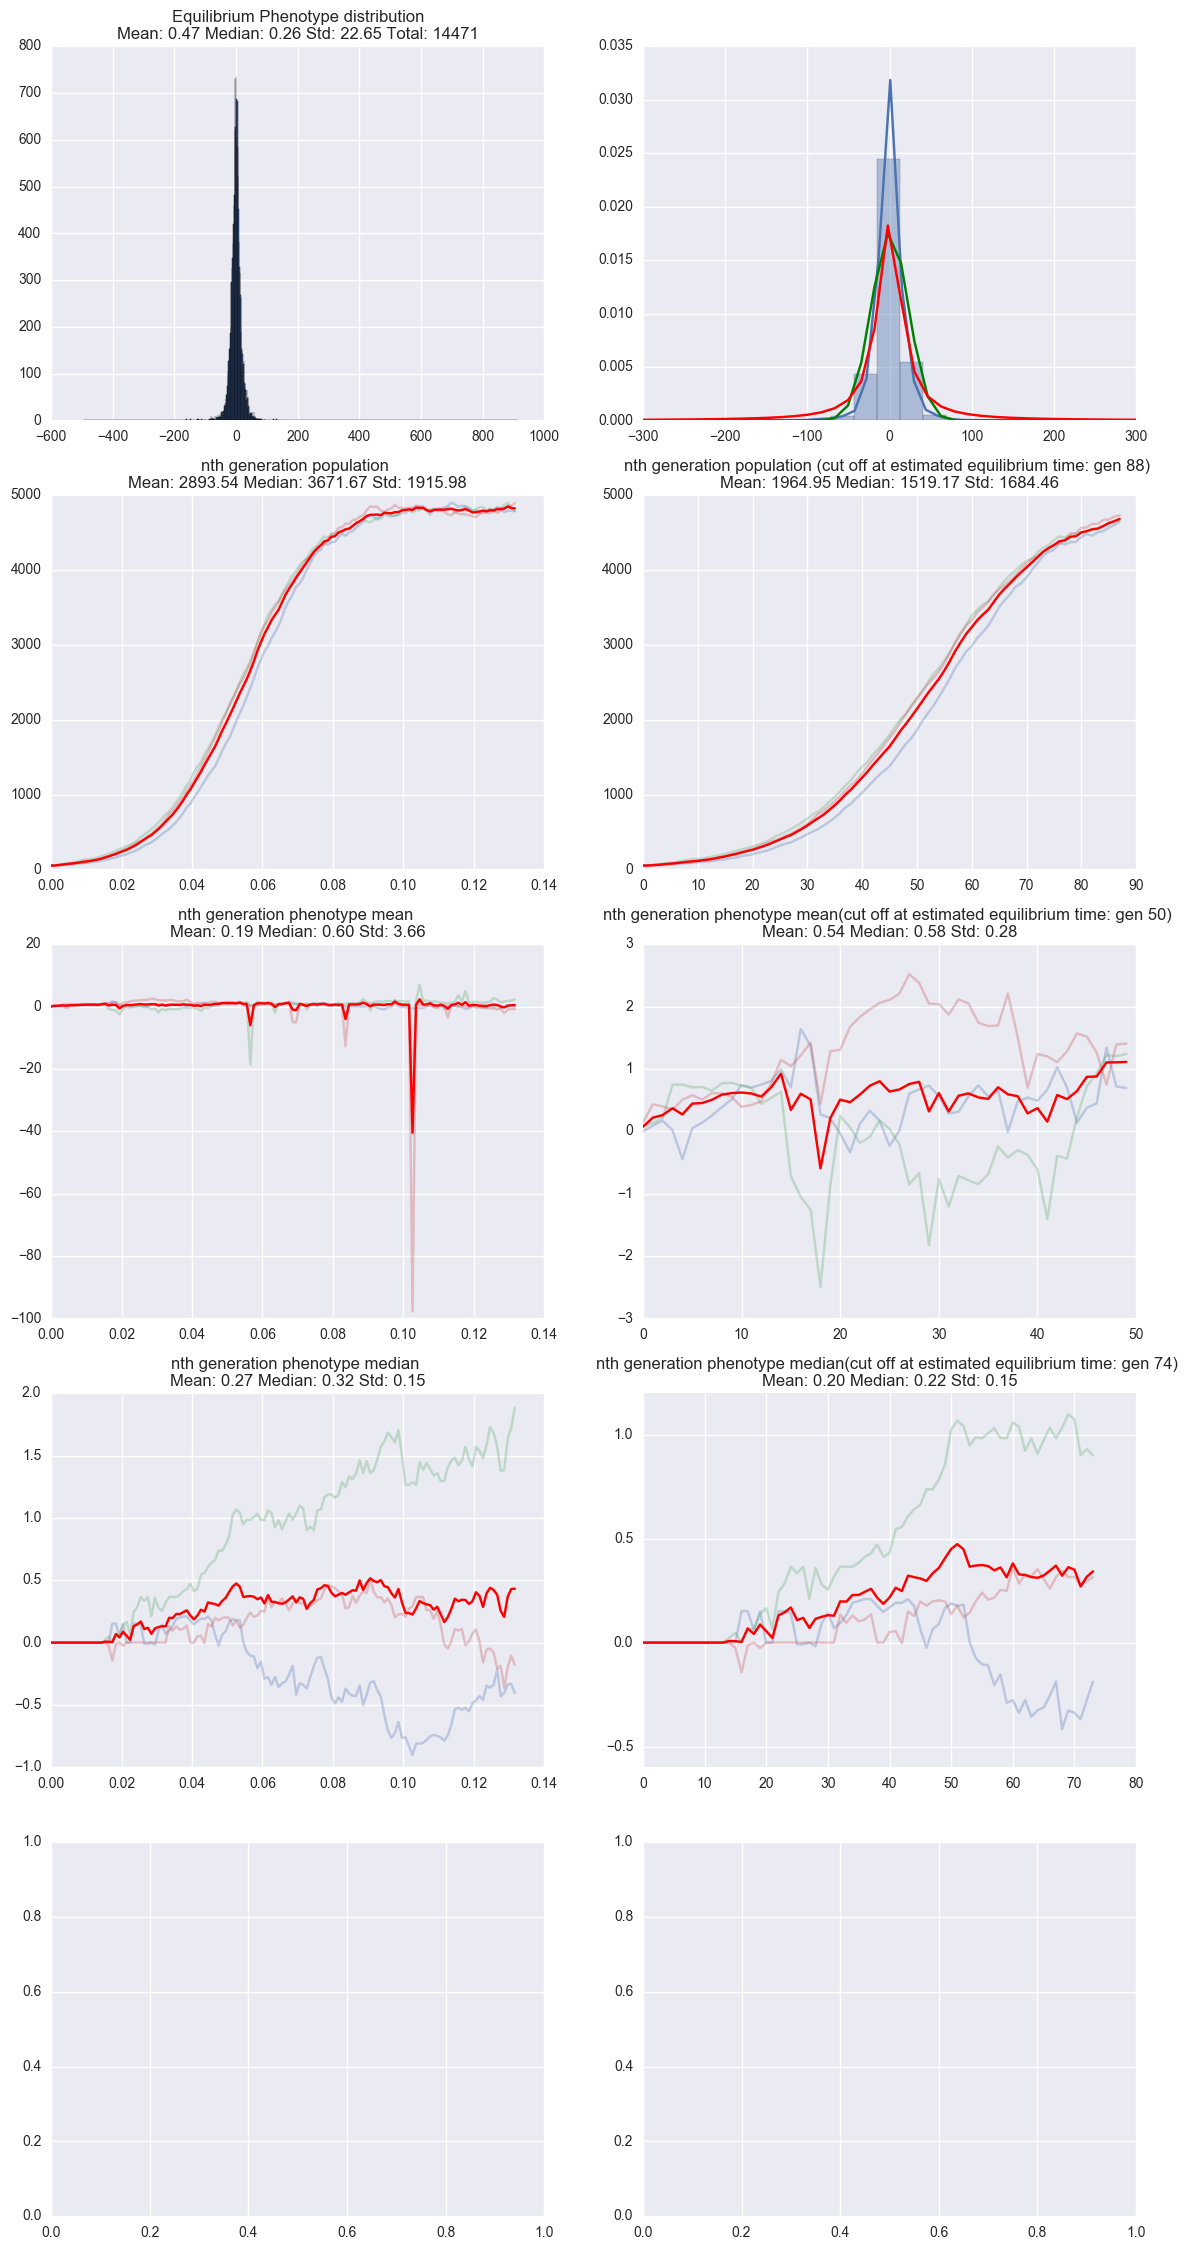

In [17]:
cauchy_sim.add_realisation(1,verbose=True)
a = cauchy_sim.report_avg_realisation(xlim=(-300, 300))

267
-200.0 200.0


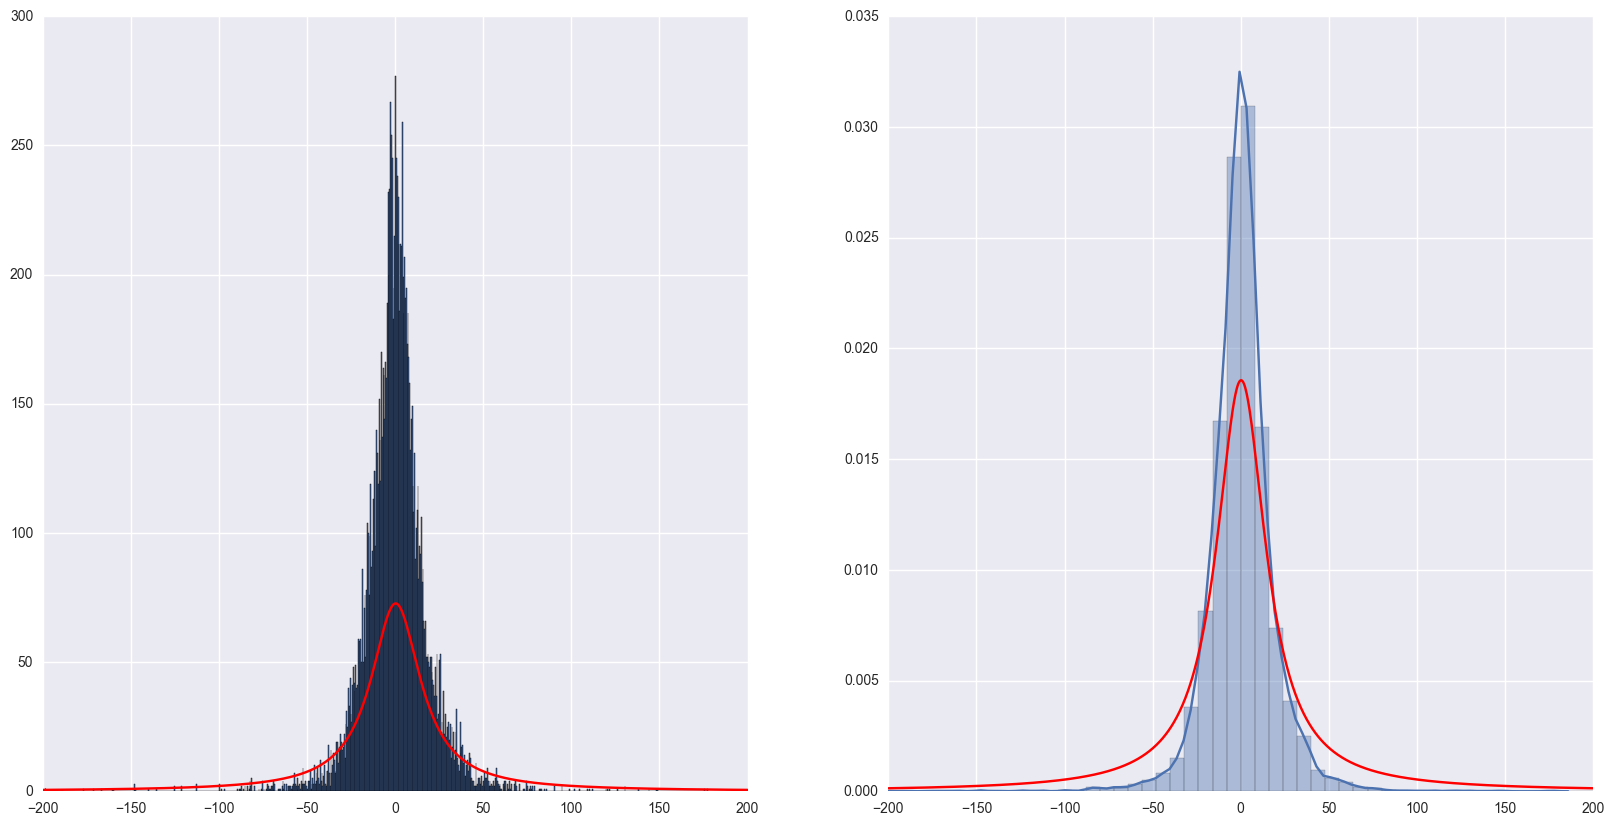

In [71]:
cauchy_mult_population = np.concatenate([[item["population_n"]] for item in cauchy_sim.realisations])
cauchy_mult_t = np.concatenate([[item["time"]] for item in cauchy_sim.realisations])
cauchy_agent_n = np.concatenate([item["agents"] for item in cauchy_sim.realisations])
cauchy_agent_n = np.array([val for val in cauchy_agent_n if np.abs(val) < 200])
equi_median = np.median(cauchy_agent_n)
equi_iqr = scipy.stats.iqr(cauchy_agent_n)


fig, ax = plt.subplots(nrows = 1, ncols =2, figsize=(20, 10))
for x in ax:
    x.set_xlim((-200, 200))
bins = compute_bins(cauchy_agent_n)
print bins
ax[0].hist(cauchy_agent_n, bins=bins*3)
xmin, xmax = ax[0].get_xlim()
ax0_xaxis = np.linspace(xmin, xmax, num=1000)
ax[0].plot(ax0_xaxis, stats.cauchy.pdf(ax0_xaxis, loc=equi_median, scale=equi_iqr) * np.sum(cauchy_agent_n), color='r')

sns.distplot(cauchy_agent_n, hist_kws={"range":(-200, 200)}, ax=ax[1])
xmin, xmax = ax[1].get_xlim()
print xmin, xmax
ax1_xaxis = np.linspace(xmin, xmax, num=1000)
ax[1].plot(ax0_xaxis, stats.cauchy.pdf(ax1_xaxis, loc=equi_median, scale=equi_iqr), color='r')


In [165]:
cauchy_sim2 = Simulate_Continuous(num_init=50, init_dist=None, 
                                 gamma=100, kappa=0.02, epsilon=100, mutation_rate=0.1, 
                                 tau=0.001, delta=0.01, num_generation=300, 
                                 walk_generator=lambda : stats.cauchy(loc=0, scale=1).rvs(1))

gen: 0, t: 0.0010 n_updates: 5 prev_size: 50 size: 51 
events: [1, 0, 4] b: 0.010583 d: 1.176776

gen: 10, t: 0.0011 n_updates: 25 prev_size: 128 size: 140 
events: [12, 0, 13] b: 0.010772 d: 0.347231

gen: 20, t: 0.0010 n_updates: 58 prev_size: 304 size: 323 
events: [21, 2, 35] b: 0.009923 d: 0.152895

gen: 30, t: 0.0010 n_updates: 147 prev_size: 629 size: 692 
events: [74, 11, 62] b: 0.009553 d: 0.072638

gen: 40, t: 0.0010 n_updates: 284 prev_size: 1316 size: 1409 
events: [131, 38, 115] b: 0.009992 d: 0.037373

gen: 50, t: 0.0010 n_updates: 541 prev_size: 2317 size: 2436 
events: [224, 105, 212] b: 0.010134 d: 0.020941

gen: 60, t: 0.0010 n_updates: 902 prev_size: 3339 size: 3409 
events: [321, 251, 330] b: 0.010145 d: 0.014148

gen: 70, t: 0.0010 n_updates: 1072 prev_size: 4126 size: 4146 
events: [365, 345, 362] b: 0.010087 d: 0.011649

gen: 80, t: 0.0010 n_updates: 1236 prev_size: 4469 size: 4524 
events: [431, 376, 429] b: 0.010015 d: 0.011020

gen: 90, t: 0.0010 n_updates: 13

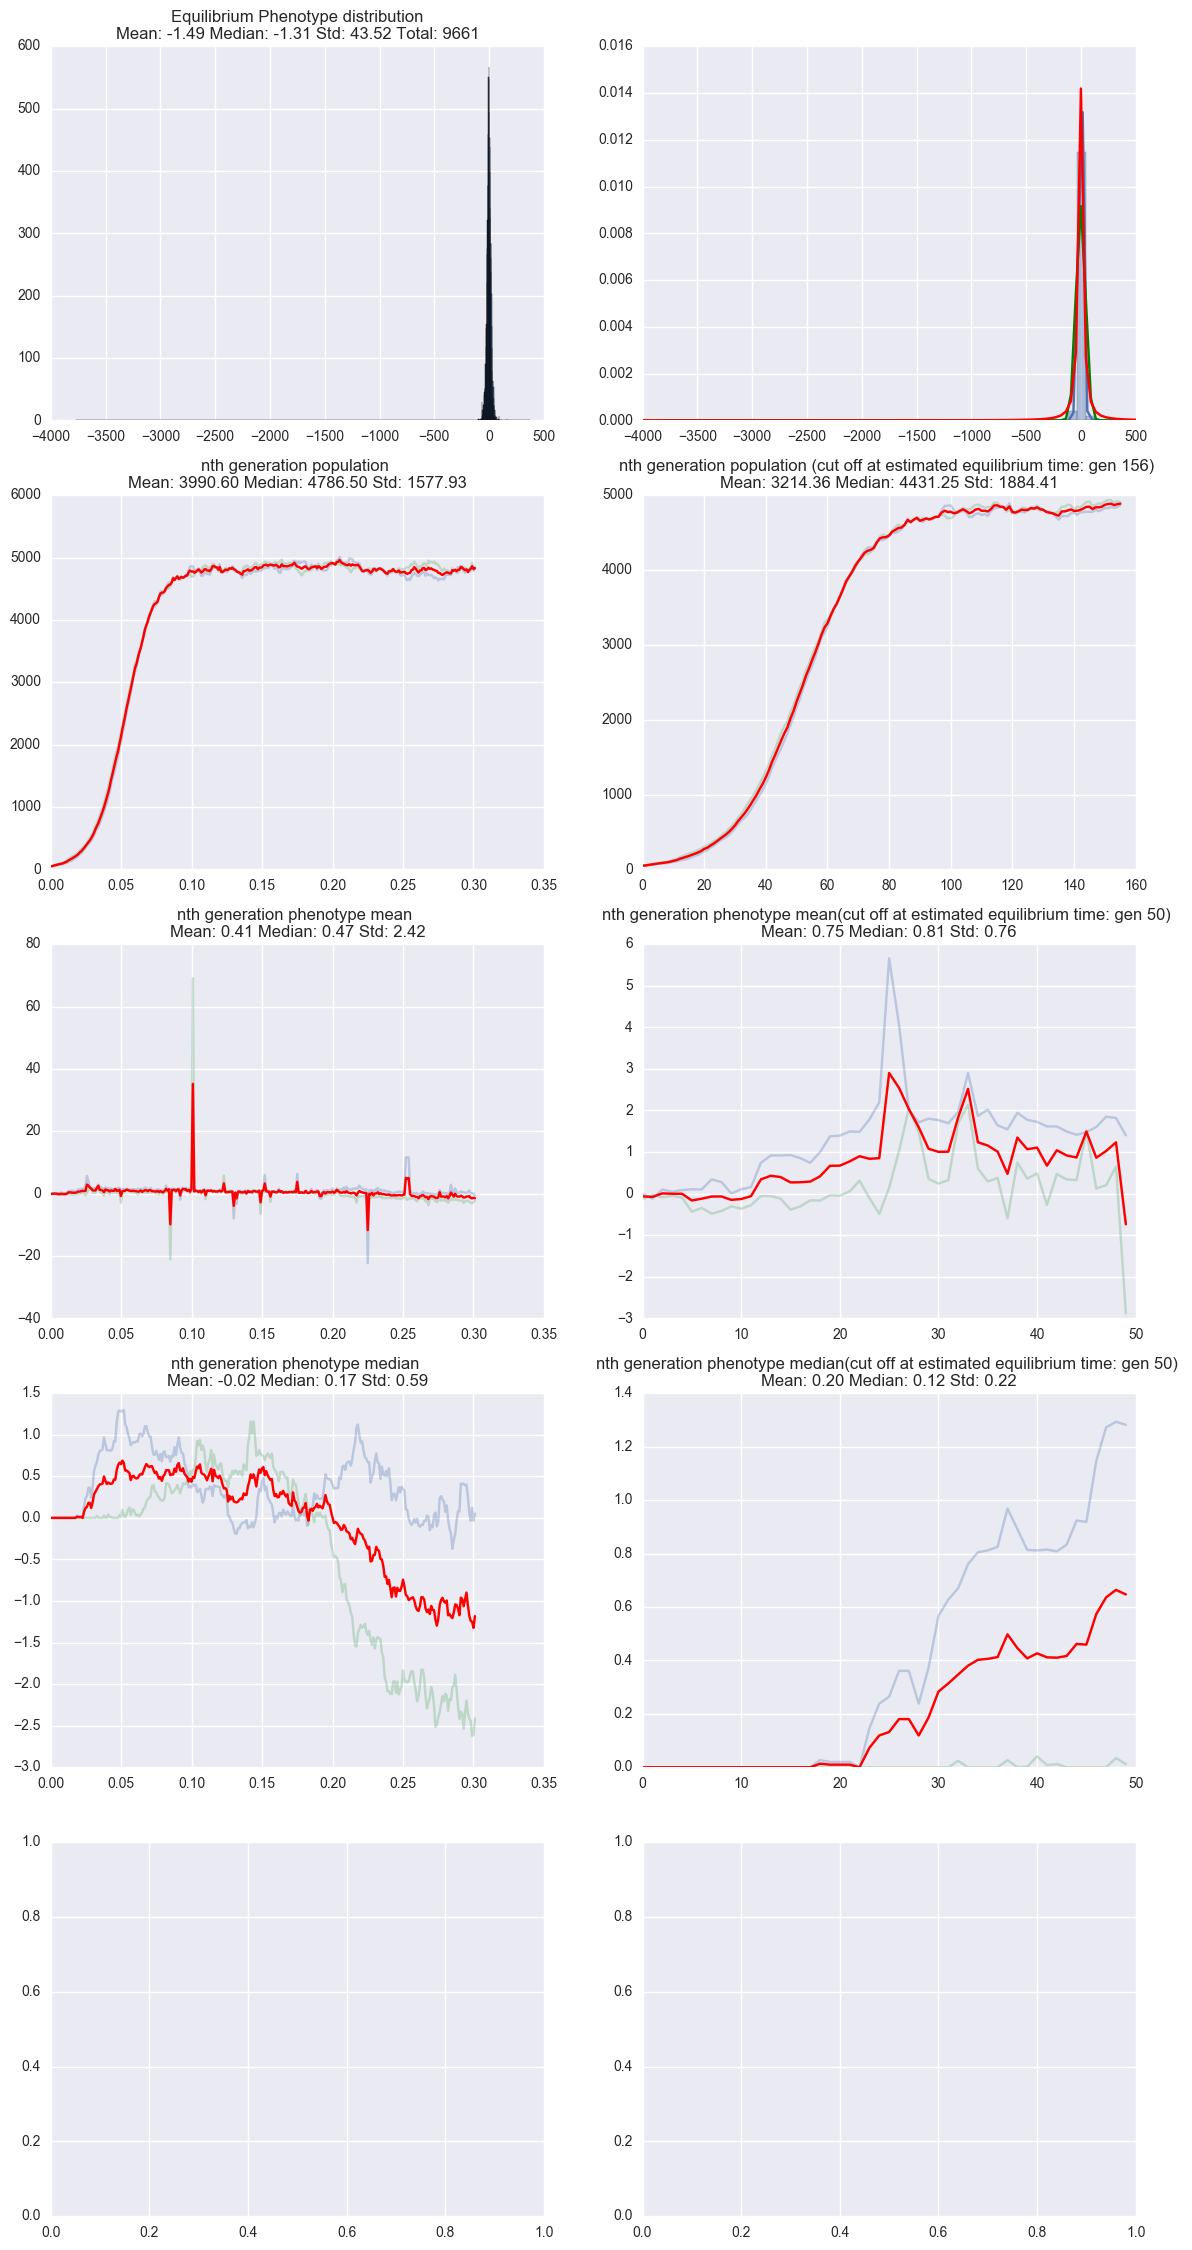

In [167]:
cauchy_sim2.add_realisation(1,verbose=True)
a = cauchy_sim2.report_avg_realisation()

In [153]:
test_sim = Simulate_Continuous(num_init=500, init_dist=None, 
                               gamma=100, kappa=0.01, epsilon=100, mutation_rate=0.1, 
                               tau=0.0001, delta=0.01, num_generation=1000, 
                               walk_generator=lambda : nearest_neighbor_walk(1, 1, 1))

Number of realisations: 3


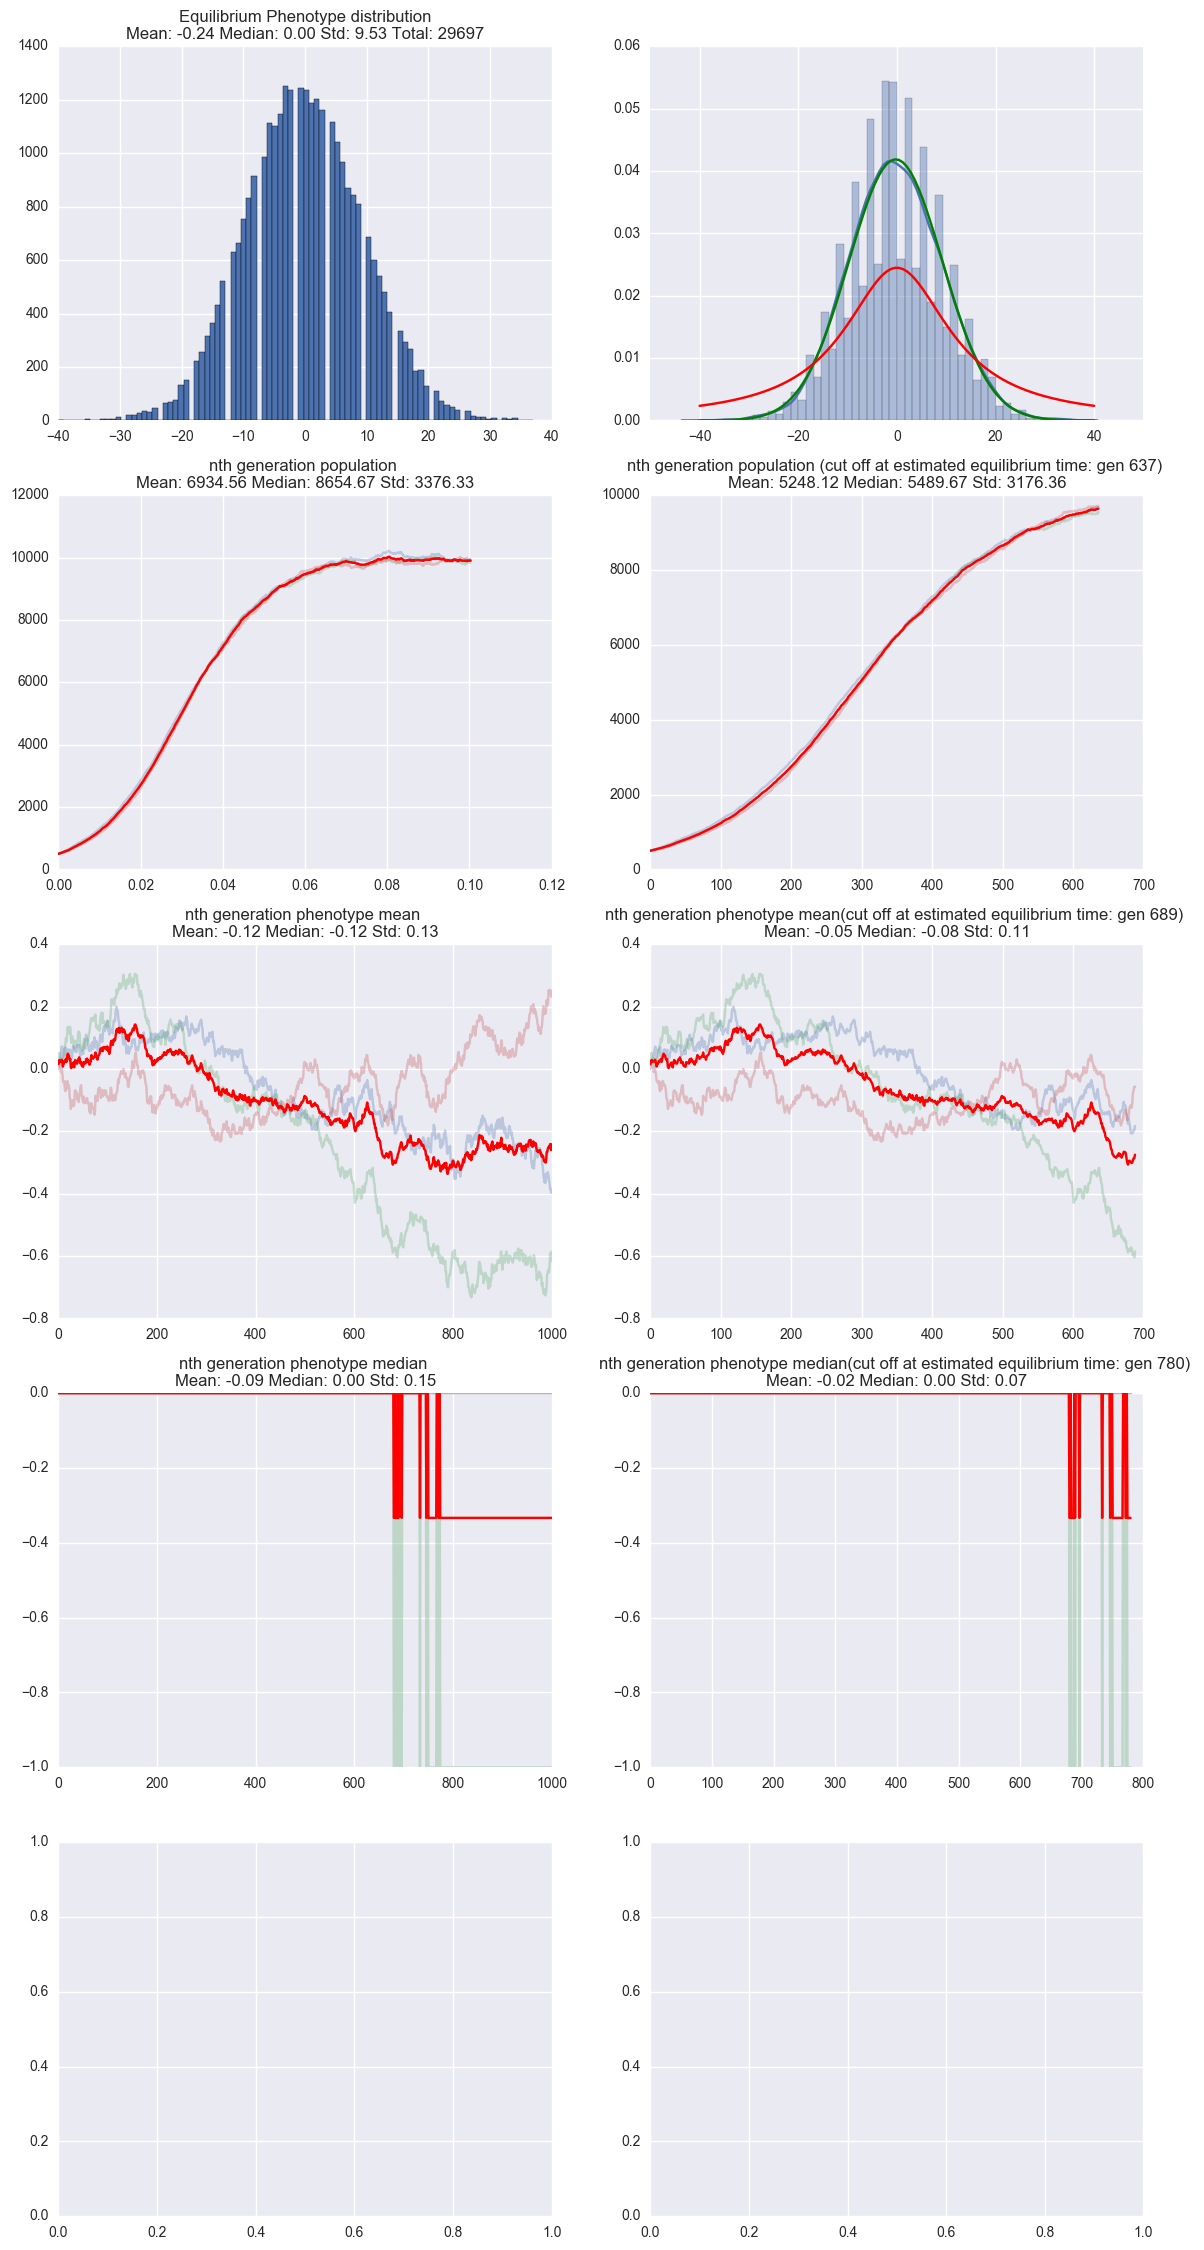

In [157]:
test_sim.add_realisation(1, verbose=True*0)
a = test_sim.report_avg_realisation()

In [99]:
test_sim2 = Simulate_Continuous(num_init=500, init_dist=None, 
                               gamma=100, kappa=0.01, epsilon=100, mutation_rate=0.1, 
                               tau=0.001, delta=0.01, num_generation=1000, 
                               walk_generator=lambda : nearest_neighbor_walk(1, 1, 1))

Number of realisations: 2


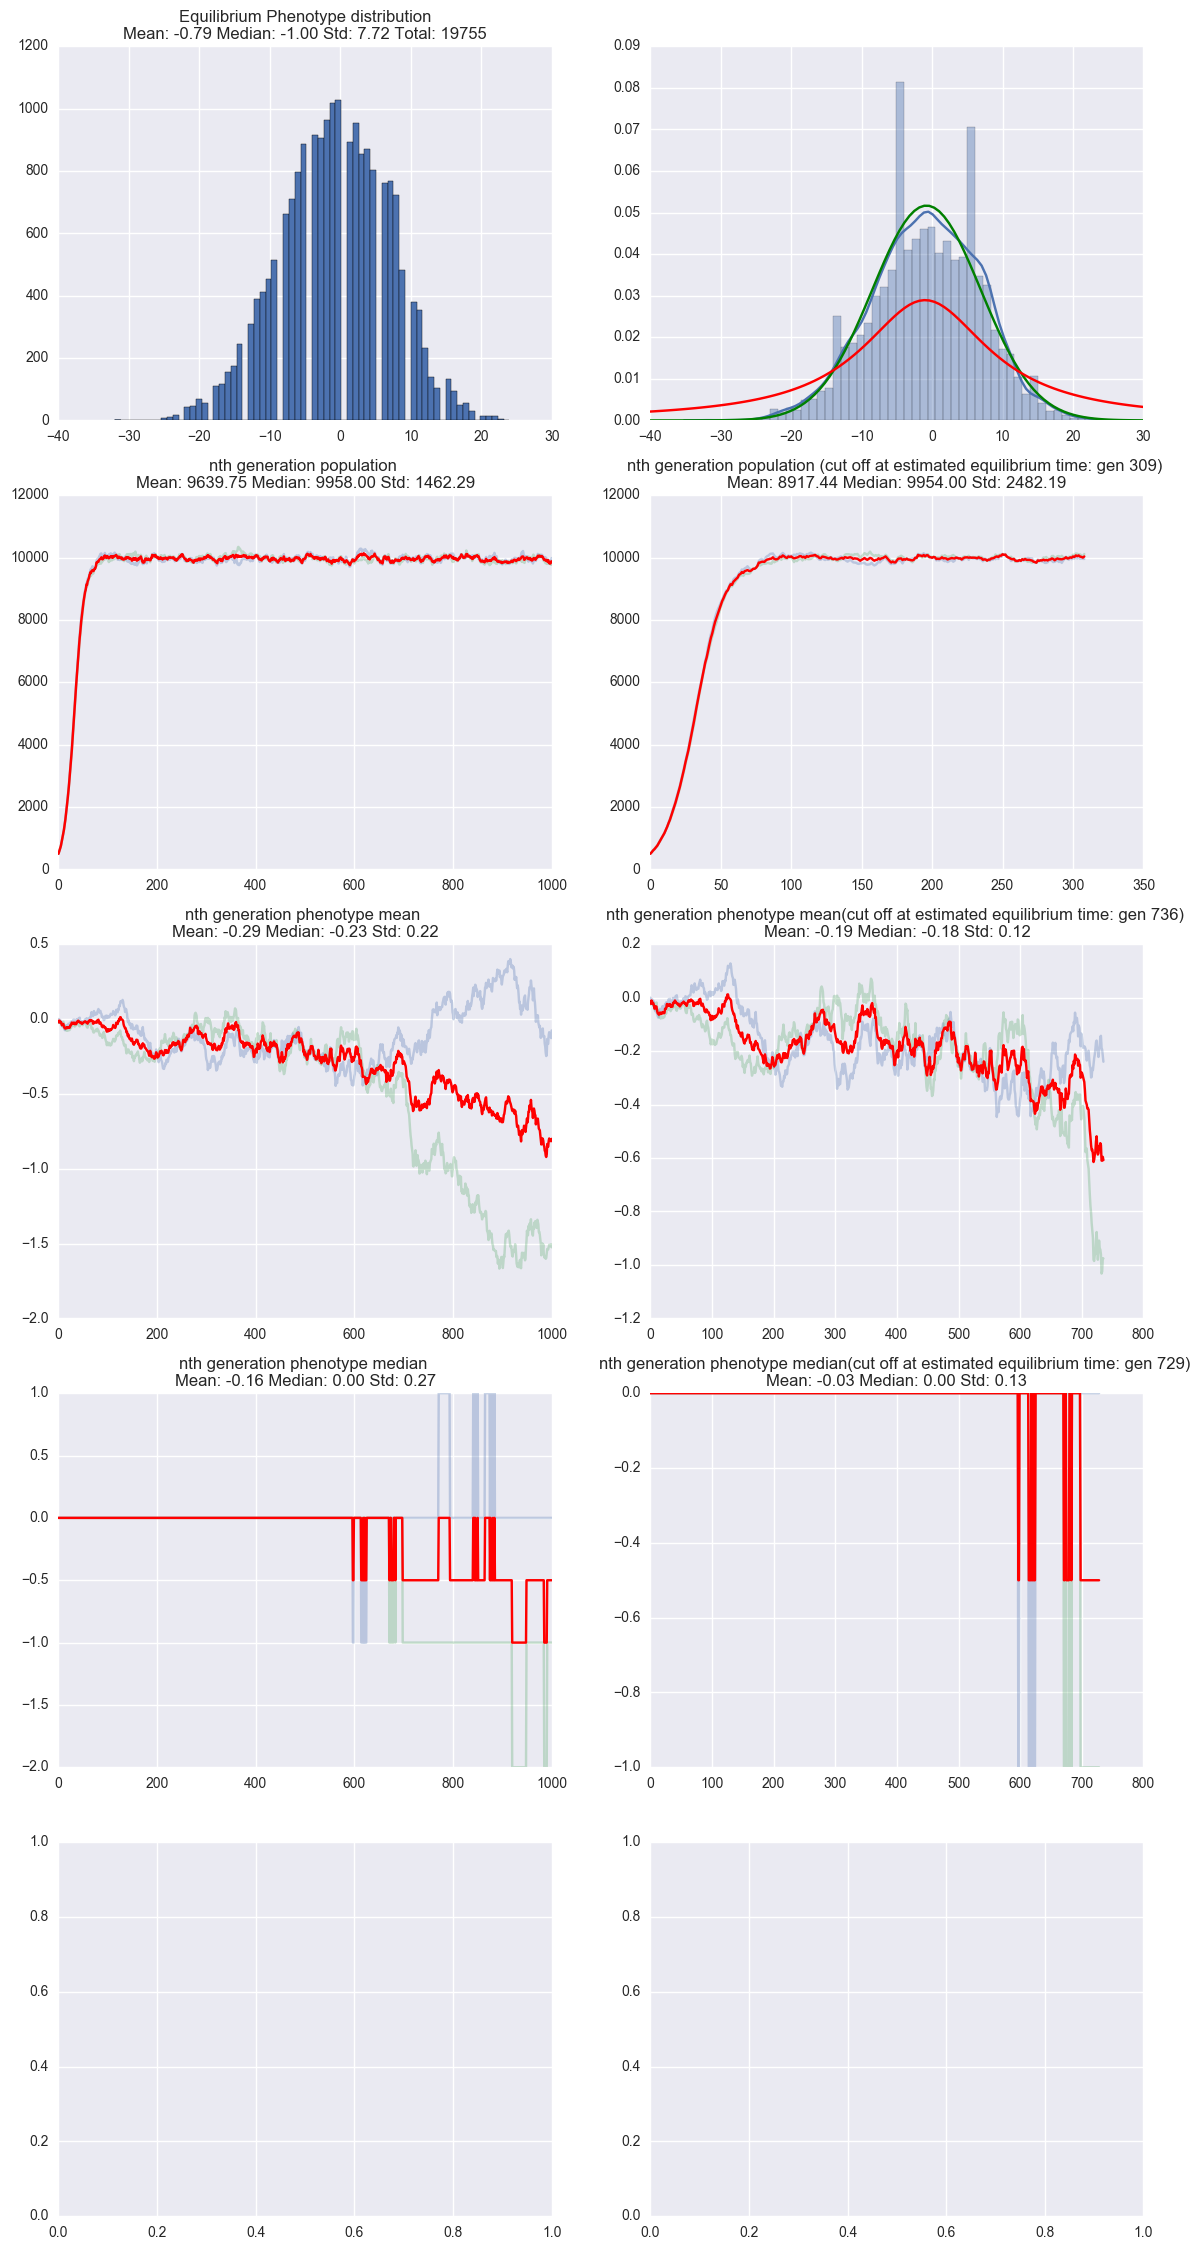

In [82]:
test_sim2.add_realisation(2)
a = test_sim2.report_avg_realisation()

## Trial continuous time simulation
---
Let's try to write a single realisation with fixed parameters to get the hang of it. 

9796 -0.00163331972234 7.201398776


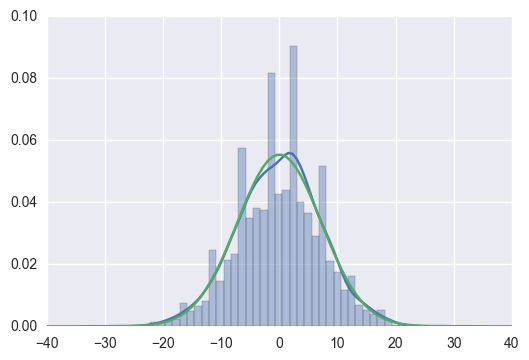

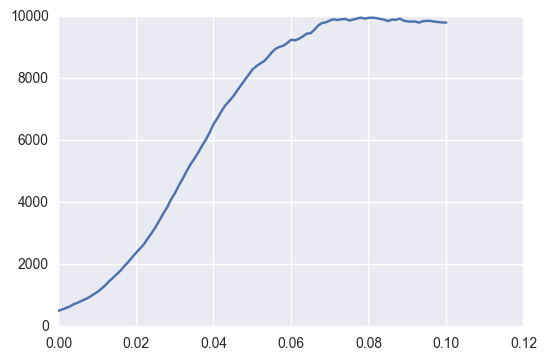

In [9]:
#%%time
# agent-based model param
tau = 0.001
delta = 0.01
gamma = 100
epsilon = 100
kappa = 0.01
num_init = 500
p = 0.9
h = 1
# simulation param
num_generation = 100

agents = np.zeros(num_init) # delta function initial distribution
pop_n = [agents.size]
ts = [0]
rvs = lambda n: nearest_neighbor_walk(n, 1, h)
mutation_rate = p / tau # exponential clock rate for mutation (random walk) to occur

t = 0
for n in range(num_generation):
    t = 0
    num_agents = agents.size
    dn = kappa * num_agents
    walk_clocks = random_exp_time(num_agents, mutation_rate) # walk rate ~ 0.01
    death_clocks = random_exp_time(num_agents, dn) # death rate ~ 5
    birth_clocks = np.zeros(num_agents)
    for i in range(num_agents):
        coord = agents[i]
        bn = gamma - epsilon * (delta * coord)**2 # birth rate ~ 50000 - 0.01 * coord **2
        birth_clocks[i] = random_exp_time(1, bn)
    clocks = np.concatenate([birth_clocks, death_clocks, walk_clocks])
    #agent_indices = np.concatenate([range(num_agents), range(num_agents), range(num_agents)])
    #events = np.concatenate([np.zeros(num_agents, dtype=np.int), 
    #                         np.ones(num_agents, dtype=np.int), 
    #                         np.ones(num_agents, dtype=np.int) * 2])
    sorted_index = clocks.argsort()
    new_agents = []
    remove_index = []
    event_tally = [0, 0, 0]
    j = 0
    t = 0
    while t < tau and j < sorted_index.size:
        index = sorted_index[j]
        event = index // num_agents
        agent_index = index % num_agents
       
        event_tally[event] += 1
        if event == 0: # birth
            new_agents.append(agents[agent_index])
        elif event == 1: # death
            remove_index.append(agent_index)
        elif event == 2: # walk
            agents[agent_index] += rvs(1)
        else:
            raise RuntimeError
        j += 1
        t = clocks[index]
    agents = np.delete(agents, remove_index)
    agents = np.append(agents, new_agents)
    pop_n.append(agents.size)
    ts.append(ts[-1] + t)
    #print agents.size
    if n % 10 == 0:
        #continue
        print ("t: %.4f n_updates: %i n: %i size: %i events: %s b: %f d: %f, new: %i, death: %i" 
               % (t, j, num_agents, agents.size, str(event_tally), 
                  birth_clocks.mean(), death_clocks.mean(), len(new_agents), len(remove_index)))
ax = plt.subplot(111)
sns.distplot(agents, ax=ax)
xmin, xmax = ax.get_xlim()
std = np.std(agents)
mean = agents.mean()
print agents.size, mean, std
xaxis = np.linspace(xmin, xmax, num=100)
ax.plot(xaxis, stats.norm.pdf(xaxis, loc=mean, scale=std))
plt.figure()
plt.plot(ts, pop_n)

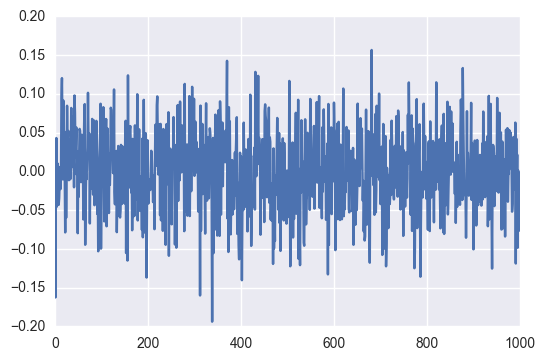

In [73]:
y = [np.median(stats.cauchy(loc=0, scale=1).rvs(1000)) for i in range(1000)]
plt.plot(range(1000), y) 